In [1]:
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [11]:
epochs=100

train_datagen = ImageDataGenerator(rotation_range=8, 
                                   width_shift_range=0.08,
                                   shear_range=0.3,
                                   height_shift_range=0.08,
                                   zoom_range=0.08)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, 
                                     y_train, 
                                     batch_size=32)

test_generator = test_datagen.flow(X_test,
                                   y_test, 
                                   batch_size=32)


data batch shape: (32, 28, 28, 1)
labels batch shape: (32,)


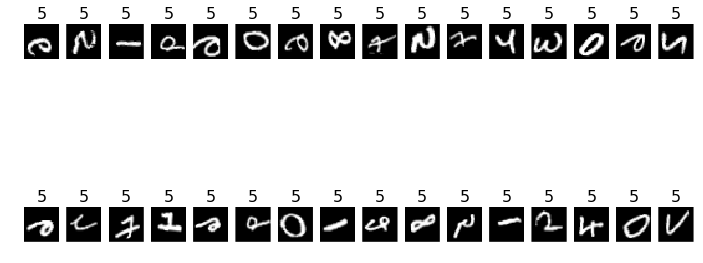

In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
data_batch, labels_batch = next(train_generator)

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3 :
            ims = ims.transpose(0,2,3,1)
    
    f = plt.figure(figsize=figsize)
    
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i].reshape(28,28), interpolation = None if interp else 'none', cmap='gray')
        
plots(data_batch, titles = labels_batch)